# Data Science with Neo4j Using Yelp Data

### Module 2: Segmentation and Community Detection (Work in Progress)

Goal: Find communities based on categories of restaurants users review      

Algorithm: Label Propagation

High Level Approach:
      
- Subset data to only include restaurants in Toronto.  Consequently, this means we are only considering users who reviewed restaurants in Toronto.
- Population:  1251 users, 1707 businesses, 81 categories
- Relationships: user REVIEWED business, business IN_CATEGORY, user REVIEWED_CATEGORY
- Create weights between users to form tighter communities (jaccard index between users based on # restaurant categories)
- Draw parallels with traditional data science clustering approaches (eg: k-means, kNN)

In [108]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo4jneo4j"))

In [110]:
%%time
# get count of businesses in each category. this will be used to determine which categories to include in our analysis
query = """
        MATCH (c:Category)
        RETURN c.name, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat   
        ORDER BY c, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False).head(10))

,c.name,num_business_in_cat
5,Nightlife,335
6,Bars,330
21,Canadian (New),232
16,Japanese,197
41,Breakfast & Brunch,188
23,Italian,159
2,Chinese,117
17,Sushi Bars,116
10,Sandwiches,110
11,American (Traditional),98


CPU times: user 22.6 ms, sys: 22.9 ms, total: 45.6 ms
Wall time: 87.6 ms


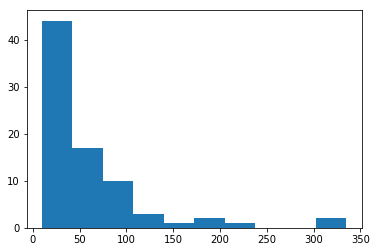

,num_business_in_cat
count,80.000000
mean,55.787500
std,63.116668
min,10.000000
0%,10.000000
25%,14.750000
50%,37.000000
75%,64.250000
80%,86.200000
85%,90.150000


In [111]:
plt.hist(result_df['num_business_in_cat'])
plt.show()  

result_df.describe([0,0.25, 0.5,0.75,0.8,0.85,0.9,0.95,1])

In [112]:
%%time
# find average number of categories a business can belong to, as well as min and max
query = """
        MATCH (b:Business)
        WITH size((b)-[:IN_CATEGORY]->()) AS count
        RETURN AVG(count) AS avgCat,  MIN(count) AS minCount, MAX(count) AS maxCat
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record avgCat=2.6678383128295287 minCount=0 maxCat=12>
CPU times: user 2.24 ms, sys: 2.52 ms, total: 4.76 ms
Wall time: 82.1 ms


In [113]:
%%time
# which business doesn't have a category?  these will be removed later
query = """
        MATCH (b:Business)
        WITH b.name as business, size((b)-[:IN_CATEGORY]->()) AS count
        WHERE count < 1
        RETURN business, count
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record business='Holt Renfrew' count=0>
<Record business='Kanga' count=0>
<Record business='Soos' count=0>
<Record business='Mustafa Turkish Pizza' count=0>
<Record business='CASA manila' count=0>
<Record business="Loga's Corner" count=0>
<Record business='Kebab 49' count=0>
<Record business='Matahari Grill' count=0>
<Record business='Platito Filipino Soul Food' count=0>
<Record business="Churrasco Villa Toronto's Original" count=0>
<Record business='Anatolia Restaurant' count=0>
<Record business='Satay Sate' count=0>
<Record business='Lamesa Filipino Kitchen' count=0>
<Record business="Julie's Cuban Restaurant" count=0>
<Record business='Bamiyan Kabob' count=0>
<Record business="Otto's Bierhalle" count=0>
<Record business='Pamier Kabob' count=0>
<Record business='Lisbon By Night Restaurant' count=0>
<Record business='Tinuno' count=0>
CPU times: user 3.31 ms, sys: 2.51 ms, total: 5.82 ms
Wall time: 42.7 ms


In [114]:
# before running label propagation, define similarity between user pairs using Jaccard index
# this will be used as the weight for Label Propagation
# numerator: count of categories that they've reviewed together
# denominator: count of categories between the two of them
# for now, keep calculation simple.  room for improvement later (ie: take into account # businesses in each category)

In [115]:
%%time
# for now, get number of businesses in a category that a user has reviewed
# create relationship between user and category
query = """
        MATCH (u:User)-[:REVIEWED]->(b:Business)-[:IN_CATEGORY]->(c:Category)
        WITH u, c, COUNT(DISTINCT b) as num_business_reviewed
        CREATE (u)-[:REVIEWED_CATEGORY {num_reviewed: num_business_reviewed}]->(c)
        """     

with driver.session() as session:
    result = session.run(query)

CPU times: user 1.97 ms, sys: 2.52 ms, total: 4.49 ms
Wall time: 2.34 s


In [116]:
%%time
query = """
    
        MATCH (u:User)-[r:REVIEWED_CATEGORY]->(c:Category)
        RETURN u.id, c.name, r.num_reviewed
        LIMIT 10
        """     

with driver.session() as session:
    result = session.run(query)
    

result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.head())
display(result_df.shape)

,c.name,r.num_reviewed,u.id
0,Coffee & Tea,2,vGZjOiKqNunNBIOFxlBFGw
1,Coffee & Tea,2,4dIxMP5--LX1X0i3s3PIAA
2,Coffee & Tea,2,w4eoQ02N63vHK6ClfV1Azw
3,Coffee & Tea,1,XHP6Kvw0UxekKpRPJjF77Q
4,Coffee & Tea,4,EgotOxec2MuH4xvIv_KRIA


(10, 3)

CPU times: user 20.5 ms, sys: 4.03 ms, total: 24.6 ms
Wall time: 88.5 ms


In [ ]:
# break up jaccard index calculation into 3 parts:  numerator, denominator, jaccard ratio

In [117]:
%%time
# get numerator which is intersection count
query = """
        // get numerator
        MATCH (u1:User)-[:REVIEWED_CATEGORY]->(c:Category)<-[:REVIEWED_CATEGORY]-(u2:User)
        WHERE id(u1) < id(u2)
        RETURN u1.id, u2.id, COUNT(DISTINCT c) as intersection_count 
        """     

with driver.session() as session:
    result = session.run(query)
    

CPU times: user 14.8 s, sys: 8.9 s, total: 23.7 s
Wall time: 6min 55s


In [119]:
%%time
# compare performance of above query to see impact of USING JOIN ON hint
query = """
        // get numerator
        MATCH (u1:User)-[:REVIEWED_CATEGORY]->(c:Category)<-[:REVIEWED_CATEGORY]-(u2:User)
        USING JOIN ON c
        WHERE id(u1) < id(u2)
        RETURN u1.id, u2.id, COUNT(DISTINCT c) as intersection_count 
        """     

with driver.session() as session:
    result = session.run(query)
    

CPU times: user 10.6 s, sys: 719 ms, total: 11.3 s
Wall time: 6min 40s


#### USING JOIN ON hint did not result in much improvement in performance

In [120]:
intersection = pd.DataFrame([dict(record) for record in result])
    
display(intersection.head())
display(intersection.shape)

,intersection_count,u1.id,u2.id
0,15,VZx_Tqu2WPgL5-A4mViyJQ,i-PZwf519Vu4ybNt9D8oEA
1,16,BXlQO-sD4R1DwXPpMwd6JA,dmjjDNiYRTyuCI3-Zmm8Pw
2,27,BXlQO-sD4R1DwXPpMwd6JA,buv4fFmsJhDfFWvOgUWxtw
3,28,C5HjsWQz-Algu8ej8DnjSA,-9RU4LuI_TfYgv9rBijJoQ
4,30,ZBllYKrFzaI0I7v6Wl26Wg,jJDUCuPwVqwjbth3s92whA


(781875, 3)

#### calculation of numerator followed by calculation of denominator takes a very long time

In [121]:
%%time
query = """
        // get numerator
        MATCH (u1:User)-[:REVIEWED_CATEGORY]->(c:Category)<-[:REVIEWED_CATEGORY]-(u2:User)
        WHERE id(u1) < id(u2)
        WITH u1, u2, COUNT(DISTINCT c) as intersection_count 
        
        // get denominator
        MATCH (u:User)-[:REVIEWED_CATEGORY]->(c:Category)
        WHERE u in [u1,u2]
        RETURN u1.id, u2.id, intersection_count, COUNT(DISTINCT c) as union_count
        """     

with driver.session() as session:
    result = session.run(query)
    

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'neo4j.bolt._io.ChunkedInputBuffer.receive'
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/ssl.py", line 1002, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/ssl.py", line 865, in read
    return self._sslobj.read(len, buffer)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/ssl.py", line 625, in read
    v = self._sslobj.read(len, buffer)
KeyboardInterrupt: 


ServiceUnavailable: Failed to read from defunct connection Address(host='127.0.0.1', port=7687)

#### split numerator calculation from denominator calculation 

In [107]:
%%time
# get denominator which is union count
query = """
        // get denominator
        MATCH (u1:User)-[:REVIEWED_CATEGORY]->(c1:Category),
              (u2:User)-[:REVIEWED_CATEGORY]->(c2:Category)
        RETURN u1, u2, COLLECT(DISTINCT [id(c1), id(c2)]) as categories
        LIMIT 5
        """     

with driver.session() as session:
    result = session.run(query)

Exception ignored in: <bound method Session.__del__ of <neo4j.v1.session.BoltSession object at 0x114aa5b00>>
Traceback (most recent call last):
  File "/Users/gtenorio/Envs/venv/lib/python3.6/site-packages/neo4j/v1/api.py", line 250, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'neo4j.bolt._io.ChunkedInputBuffer.receive'
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/ssl.py", line 1002, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/ssl.py", line 865, in read
    return self._sslobj.read(len, buffer)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/ssl.py", line 625, in read
    v = self._sslobj.read(len, buffer)
KeyboardInterrupt: 


ServiceUnavailable: Failed to read from defunct connection Address(host='127.0.0.1', port=7687)

In [ ]:
union = pd.DataFrame([dict(record) for record in result])
    
display(union.head())
display(union.shape)

In [ ]:
# need to incorporate weights between user pairs in order to create tighter communities
# weightProperty - Jaccard index
# need to adjust query below

In [92]:
%%time
query = """
        CALL algo.labelPropagation(
            'MATCH (u:User)-[:REVIEWED_CATEGORY]->(:Category) RETURN id(u) as id',   
            
            'MATCH (u1:User)-[:REVIEWED_CATEGORY]->(c:Category)<-[:REVIEWED_CATEGORY]-(u2:User)
             RETURN DISTINCT id(u1) as source, id(u2) as target', 
             'OUTGOING',
            {graph: 'cypher', iterations:10, partitionProperty:'cluster', write: true})
        YIELD nodes, iterations, didConverge, loadMillis, computeMillis, writeMillis, write, partitionProperty;
        """

with driver.session() as session:
    result = session.run(query)
    
for row in result:
    print(row)

<Record nodes=6764792 iterations=10 loadMillis=29382 computeMillis=25497 writeMillis=39893 write=True partitionProperty='partition'>
CPU times: user 6.12 ms, sys: 9.46 ms, total: 15.6 ms
Wall time: 1min 34s


In [100]:
%%time
# check number of communities
query = """
        MATCH (u:User)
        RETURN count(DISTINCT u.partition)
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record count(DISTINCT u.partition)=872>
CPU times: user 2.39 ms, sys: 3.24 ms, total: 5.63 ms
Wall time: 1.99 s


In [101]:
%%time
# check number of business partitions????
query = """
        MATCH (b:Business)
        RETURN count(DISTINCT b.partition)
        """

with driver.session() as session:
    result = session.run(query)

for row in result:
    print(row)

<Record count(DISTINCT b.partition)=196>
CPU times: user 2.04 ms, sys: 3.18 ms, total: 5.23 ms
Wall time: 358 ms


In [ ]:
%%time
# remove partition
query = """
        MATCH (n:Review)
        REMOVE n.partition 
        RETURN n
        """

with driver.session() as session:
    result = session.run(query)